Loading Dependencies:

In [2]:
import pandas as pd
import numpy as np
import os
import cv2 as cv 
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory

Check if GPU is available:

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10568741061931969437
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732564992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17184571339653157543
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


#  Importing the data

We downloaded the data from the following source: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri



In [4]:
# All the folders in the training directory
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dir = "./data/Training/"
test_dir = "./data/Testing/"

# Initialize image & batch size
IMG_SIZE = 300
batch_size = 20

In [43]:
# Augmenting the training data lowered our test accuracy
train_datagen = ImageDataGenerator(
        rescale=1./255,
      )

# No augmentation on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate with flow from directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        color_mode='rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)

# Generate with flow from directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        color_mode='rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [6]:
keys = train_generator.class_indices
keys

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [7]:
def get_key(val):
    for key, value in keys.items():
        if val == value:
            return key
 
    return "key doesn't exist"


get_key(0)

'glioma_tumor'

Showing some of the augmented images:

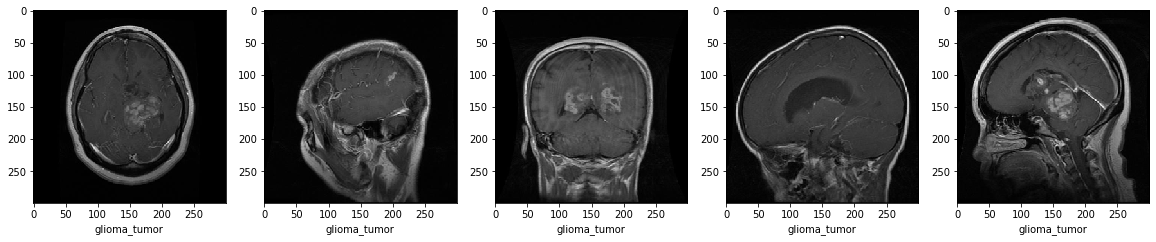

In [8]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = train_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Showing some unaugmented pictures:

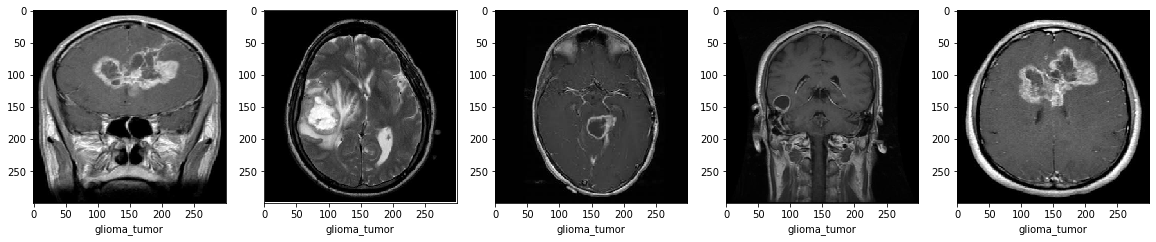

In [9]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = test_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Create the training/testing Y & X:

In [10]:
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(300, 300, 3),
    include_top=False)

base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 300, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(4, activation = "softmax")
])

# Building the Neural Network

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 10) 

Epoch 1/10


C:\Users\felix\AppData\Local\Temp\ipykernel_20320\694823855.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 10)


143/143 [==============================] - 15s 68ms/step - loss: 1.3453 - accuracy: 0.5996 - val_loss: 1.0633 - val_accuracy: 0.6263
Epoch 2/10
143/143 [==============================] - 9s 65ms/step - loss: 0.4692 - accuracy: 0.8253 - val_loss: 1.0837 - val_accuracy: 0.7026
Epoch 3/10
143/143 [==============================] - 9s 65ms/step - loss: 0.2986 - accuracy: 0.8919 - val_loss: 1.1100 - val_accuracy: 0.7474
Epoch 4/10
143/143 [==============================] - 9s 64ms/step - loss: 0.1881 - accuracy: 0.9270 - val_loss: 1.2085 - val_accuracy: 0.7605
Epoch 5/10
143/143 [==============================] - 9s 64ms/step - loss: 0.1290 - accuracy: 0.9551 - val_loss: 1.2740 - val_accuracy: 0.7658
Epoch 6/10
143/143 [==============================] - 9s 65ms/step - loss: 0.0864 - accuracy: 0.9737 - val_loss: 1.0887 - val_accuracy: 0.7974
Epoch 7/10
143/143 [==============================] - 9s 65ms/step - loss: 0.0633 - accuracy: 0.9796 - val_loss: 1.2865 - val_accuracy: 0.7947
Epoch 8/1

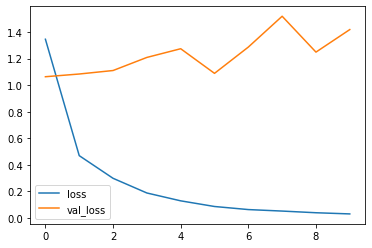

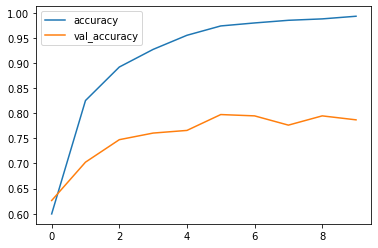

In [14]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


In [52]:
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

predictions = model.predict(test_generator)

20/20 [==============================] - 1s 51ms/step - loss: 1.3685 - accuracy: 0.7944
test loss, test acc: [1.3685179948806763, 0.7944162487983704]
20/20 [==============================] - 1s 49ms/step


In [53]:
pred_classes = np.argmax(predictions, axis=-1)

model.evaluate_generator(test_generator)

C:\Users\felix\AppData\Local\Temp\ipykernel_20320\4184460290.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[1.3685179948806763, 0.7944162487983704]

By hand we get the same accuracy:

In [54]:
sum(test_generator.classes == pred_classes)/test_generator.n

0.7944162436548223

# Model Evaluation

We have an accuracy of about 80%, but it's way more important to know if we actually diagnose patients with a form of tumor when we spot a tumor. A medical clinicus could then extrapolate the type of tumor. 
So let's check if we precicted class 2 (no-tumor) for any of the classes that actually had a tumor.

First we create an array that gives a boolean based on the matching predictions

In [55]:
# Boolean array of our correct predictions
pred_diff = test_generator.classes == pred_classes

# We cant to know which ones we had wrong so invert it.
inv_pred_diff = np.invert(pred_diff)

The model never classified a photo containing a tumor as a mri scan without a tumor, so we have good sensitivity:

In [56]:
# Real classes of the mistakes made
real_classes_mistakes = test_generator.classes[inv_pred_diff]

# Predicted classes of the mistakes made
predicted_classes_mistakes = pred_classes[inv_pred_diff]

# Check if we ever predicted 2 (no-tumor) for actual tumors
sum(real_classes_mistakes[predicted_classes_mistakes != 2] == 2)

0

Notably: None of our mistakes actually get classified as a non-tumor:

In [57]:
sum(real_classes_mistakes == 2)

0

We can also check if we ever predicted a tumor for people who actually had no tumor. <br>
This is where the model makes it's mistakes. The specificity of the model something much to be desired. <br> <br>
It classifies 18 photo's that don't have a tumor incorrectly as having a tumor:


In [108]:
len(real_classes_mistakes[predicted_classes_mistakes == 2] != 2)

18

# Testing the model on a different dataset
 
In this next part we load a different dataset from this kaggle link: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection <br>
The following is for exercise purposes only but can provide a nice insight into: the (non-)generizability of our model. Unfortunatly the images are just classified binary in this dataset (YES/NO). <br>
We don't know if the fmri images are actually the same types of tumors that we trained the model for, but as this is an exercise let's try it out and draw our conclusions afterwards.


*Loading the data:*

In [83]:
# Generate with flow from directory
binary_dir = "./data/Binary/"
# No augmentation on the test data
binary_datagen = ImageDataGenerator(rescale=1./255)

binary_generator = binary_datagen.flow_from_directory(
        binary_dir,
        color_mode='rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)

Found 253 images belonging to 2 classes.


Making predictions:

In [88]:
new_data_pred  = model.predict_generator(binary_generator)

new_data_pred_classes = np.argmax(new_data_pred, axis=-1)

C:\Users\felix\AppData\Local\Temp\ipykernel_20320\2268819410.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  new_data_pred  = model.predict_generator(binary_generator)


253

In [89]:
binary_list  = []


for i, ele in enumerate(new_data_pred_classes):
    if ele == 2:
        binary_list.append(0)
    else:
        binary_list.append(1)


In [90]:
binary_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,


Our model made quite robust predictions to the new dataset. <br>
However keep in mind that the data is now binary, so the improvement compared to guessing is actually not that large. <br>
The stakes are also way to high to accept a 77,8% accuracy. 

In [116]:
sum(binary_generator.classes == binary_list)/len(binary_generator.classes)


0.7786561264822134

Let's check how the mistakes are made:

In [123]:
binary_mistakes = binary_generator.classes == binary_list
binary_mistakes = np.invert(binary_mistakes)
sum(binary_mistakes)

56

Lot's of mistakes in clasifying `non-tumors(0)` and `tumors(1)`. This model is not ready for the real world! (ofcourse):

In [124]:
binary_generator.classes[binary_mistakes]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])